In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import cauchy, norm

In [3]:
# Функции распределений с прошлого занятия
# Равномерное распределение
def create_uniform_sequence(seq_len, min_val, max_val):
    result_sequence = [random.uniform(min_val, max_val) for _ in range(seq_len)]
    return result_sequence

# Сумма равномерно распределённых чисел
def create_sum_uniform_sequence(seq_len, min_val, max_val, num_sum):
    result_sequence = [sum(random.uniform(min_val, max_val) for _ in range(num_sum)) for _ in range(seq_len)]
    return result_sequence

# Нормальное распределение
def create_normal_sequence(seq_len, avg=0, std_dev=1):
    # Генерация последовательности с нормальным распределением с параметрами avg и std_dev
    result_sequence = [random.gauss(avg, std_dev) for _ in range(seq_len)]
    return result_sequence

# Распределение Коши
def create_cauchy_sequence(seq_len, loc=0, scale_factor=1):
    # Генерация последовательности с распределением Коши, с параметрами loc и scale_factor
    result_sequence = cauchy.rvs(loc=loc, scale=scale_factor, size=seq_len)
    return result_sequence

# Генерация выборки для различных распределений
def generate_sequence(size, dist_type='normal', dist_params=None):
    if dist_type == 'normal':
        return np.random.normal(dist_params['mean'], dist_params['std'], size)
    elif dist_type == 'uniform':
        return np.random.uniform(dist_params['low'], dist_params['high'], size)
    elif dist_type == 'sum_of_uniform':
        return create_sum_uniform_sequence(size, dist_params['low'], dist_params['high'], dist_params['count'])


In [19]:
seq_sizes = [10, 100, 1000]
n_iterations = 10**2
alpha = 0.05
a, b = -1, 1

#**Номер 2**

In [17]:
# Вычисление доверительных интервалов
def calculate_ci(seq, var):
    #зная дисперсию
    avg_val = np.mean(seq)
    std_error = np.sqrt(var) / np.sqrt(len(seq))
    ci_lower = avg_val - norm.ppf(1 - alpha/2) * std_error
    ci_upper = avg_val + norm.ppf(1 - alpha/2) * std_error
    return ci_lower, ci_upper

# Jackknife метод для доверительных интервалов
def jackknife_ci_method(seq, alpha=0.05):
    seq_len = len(seq)
    avg_val = np.mean(seq)
    jackknife_avg = np.array([np.mean(np.delete(seq, i)) for i in range(seq_len)])
    std_error_jackknife = np.sqrt((seq_len - 1) / seq_len * np.sum((jackknife_avg - np.mean(jackknife_avg))**2))

    z_value = norm.ppf(1 - alpha / 2)
    ci_lower = avg_val - z_value * std_error_jackknife
    ci_upper = avg_val + z_value * std_error_jackknife
    return ci_lower, ci_upper

# Bootstrap метод для доверительных интервалов
def bootstrap_ci_method(seq, alpha=0.05, iterations=1000):
    seq_len = len(seq)
    bootstrap_avg = []
    for _ in range(iterations):
        bootstrap_sample = np.random.choice(seq, size=seq_len, replace=True)
        bootstrap_avg.append(np.mean(bootstrap_sample))

    lower_bound = np.percentile(bootstrap_avg, 100 * (alpha / 2))
    upper_bound = np.percentile(bootstrap_avg, 100 * (1 - alpha / 2))
    return lower_bound, upper_bound

In [18]:
# Вычисление доверительных интервалов для различных методов
def compute_interval_bounds(seq_sizes, iter_count, technique='jackknife', dist_type='normal', dist_params=None, conf_level=0.05):
    # Списки для хранения нижних и верхних границ доверительных интервалов
    ci_lower_list = []
    ci_upper_list = []

    for size in seq_sizes:
        lower_bounds = []
        upper_bounds = []

        for _ in range(iter_count):
            sequence = generate_sequence(size, dist_type, dist_params)
            if technique == 'jackknife':
                ci_lower, ci_upper = jackknife_ci_method(sequence, conf_level)
            elif technique == 'bootstrap':
                ci_lower, ci_upper = bootstrap_ci_method(sequence, conf_level, iter_count)
            elif technique == 'normal':
                ci_lower, ci_upper = calculate_ci(sequence, conf_level)
            lower_bounds.append(ci_lower)
            upper_bounds.append(ci_upper)

        ci_lower_list.append(np.mean(lower_bounds))
        ci_upper_list.append(np.mean(upper_bounds))

    return ci_lower_list, ci_upper_list

# Построение графиков доверительных интервалов для нескольких методов
def visualize_interval_bounds(seq_sizes, bounds_info_list):
    plt.figure(figsize=(10, 6))

    # Цвета для графиков
    graph_colors = ['blue', 'orange', 'green']

    for idx, (ci_lower_list, ci_upper_list, dist_label, technique_label) in enumerate(bounds_info_list):
        graph_color = graph_colors[idx % len(graph_colors)]
        plt.plot(seq_sizes, ci_lower_list, marker='o', label=f'Нижняя граница ({dist_label}, {technique_label})', color=graph_color)
        plt.plot(seq_sizes, ci_upper_list, marker='o', label=f'Верхняя граница ({dist_label}, {technique_label})', color=graph_color)

    plt.axhline(0, color='gray', linestyle='--', label='0')
    plt.xscale('log')
    plt.xlabel('Размер выборки (логарифмическая шкала)')
    plt.ylabel('Границы доверительного интервала')
    plt.title('Границы доверительных интервалов в зависимости от размера выборки')
    plt.legend()
    plt.grid()
    plt.show()

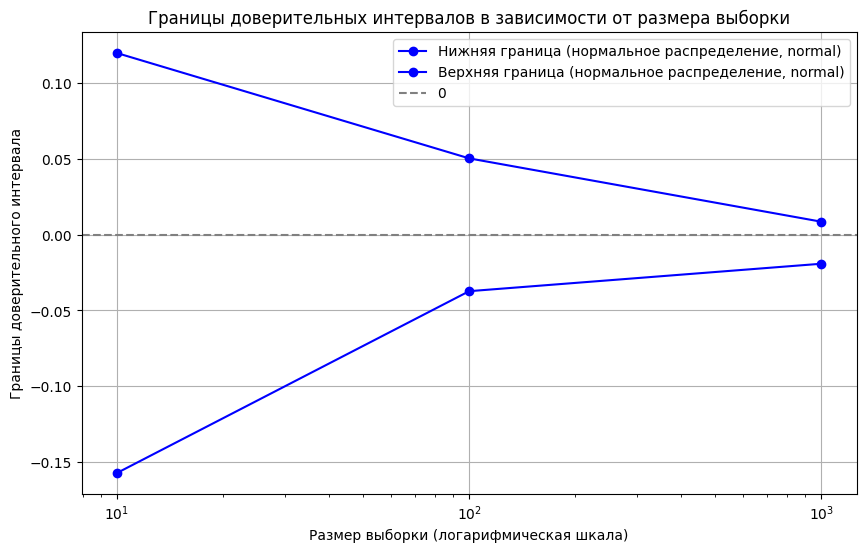

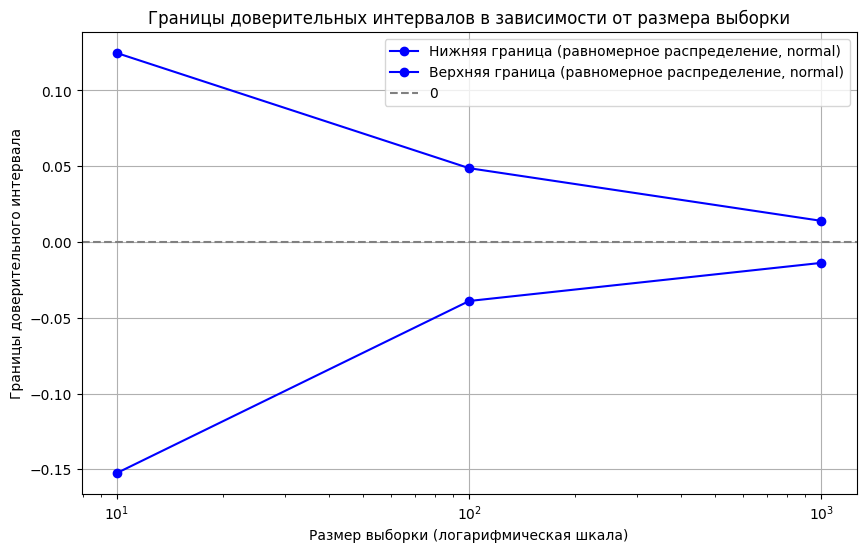

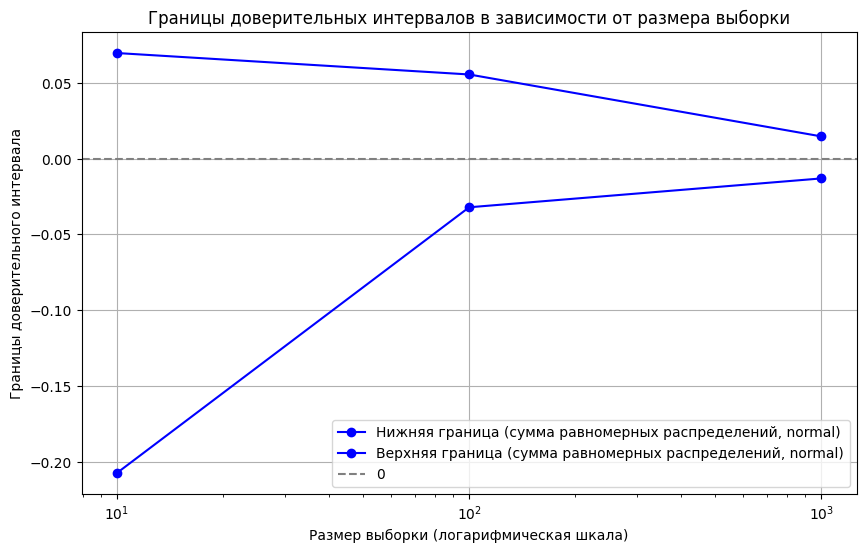

In [20]:
# Параметры распределений
dist_bounds_list = []

# Нормальное распределение
normal_params = {'mean': 0, 'std': 1}
ci_lower_normal, ci_upper_normal = compute_interval_bounds(seq_sizes, n_iterations, 'normal', 'normal', normal_params, alpha)
dist_bounds_list.append((ci_lower_normal, ci_upper_normal, 'нормальное распределение', 'normal'))
visualize_interval_bounds(seq_sizes, dist_bounds_list)

# Равномерное распределение
dist_bounds_list = []
uniform_params = {'low': -1, 'high': 1}
ci_lower_uniform, ci_upper_uniform = compute_interval_bounds(seq_sizes, n_iterations, 'normal', 'uniform', uniform_params, alpha)
dist_bounds_list.append((ci_lower_uniform, ci_upper_uniform, 'равномерное распределение', 'normal'))
visualize_interval_bounds(seq_sizes, dist_bounds_list)

# Сумма равномерных распределений
dist_bounds_list = []
sum_uniform_params = {'low': -1, 'high': 1, 'count': 2}
ci_lower_sum_uniform, ci_upper_sum_uniform = compute_interval_bounds(seq_sizes, n_iterations, 'normal', 'sum_of_uniform', sum_uniform_params, alpha)
dist_bounds_list.append((ci_lower_sum_uniform, ci_upper_sum_uniform, 'сумма равномерных распределений', 'normal'))
visualize_interval_bounds(seq_sizes, dist_bounds_list)



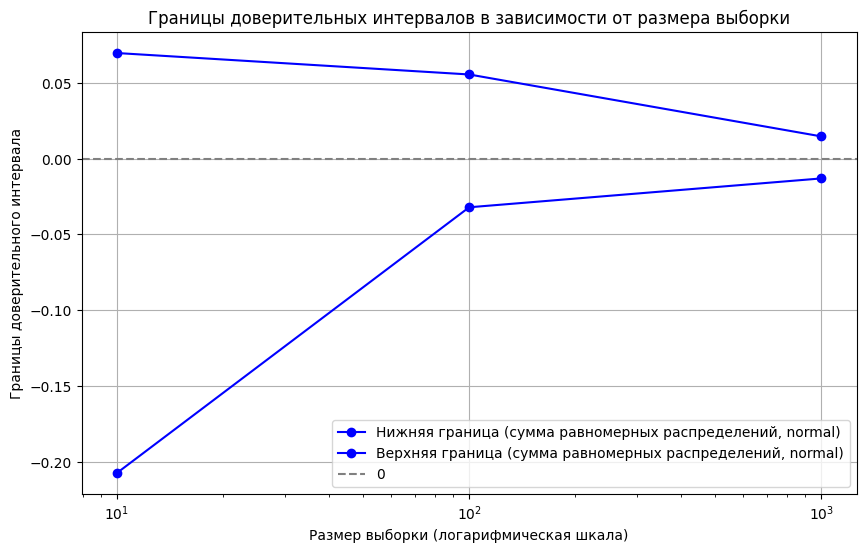

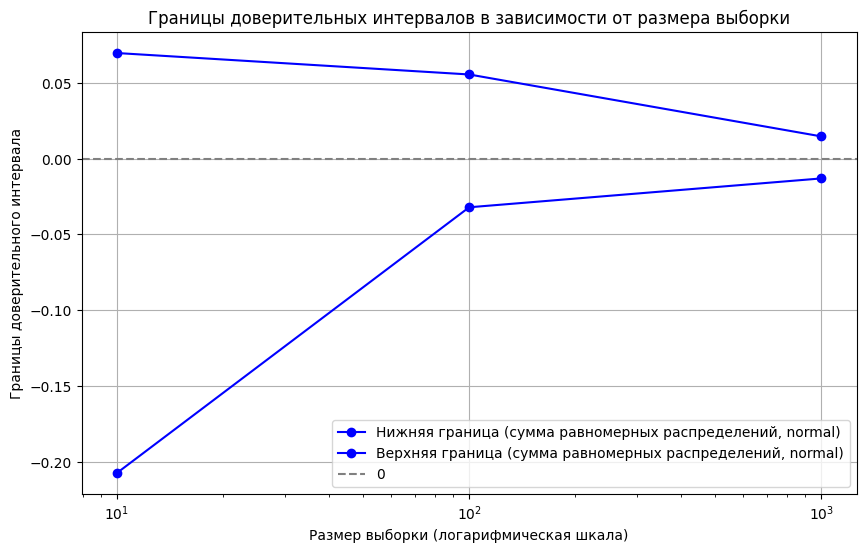

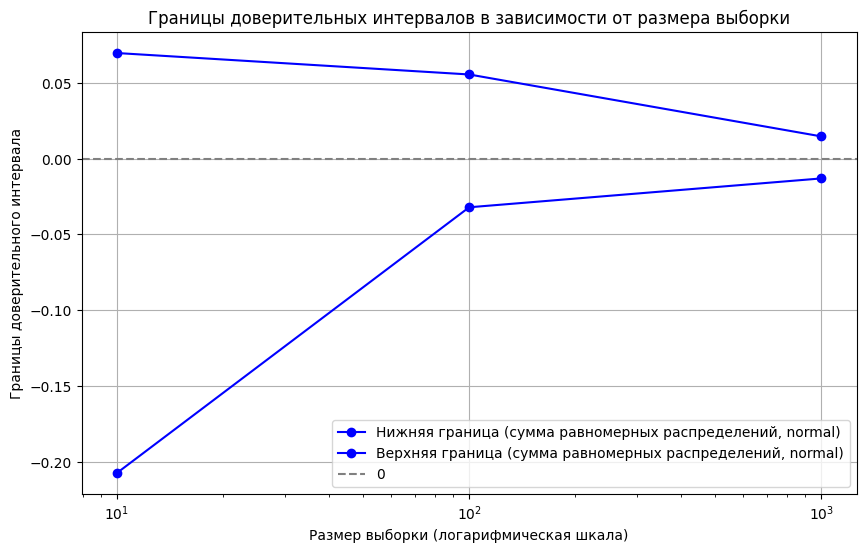

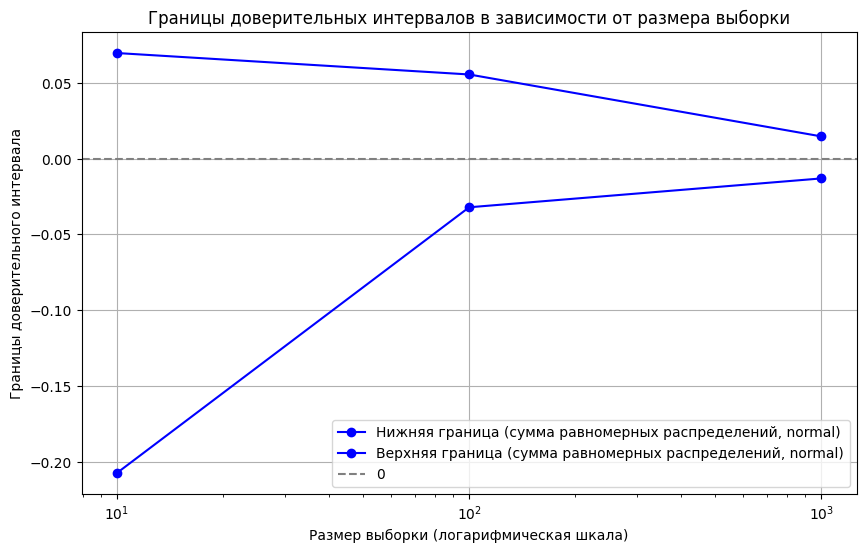

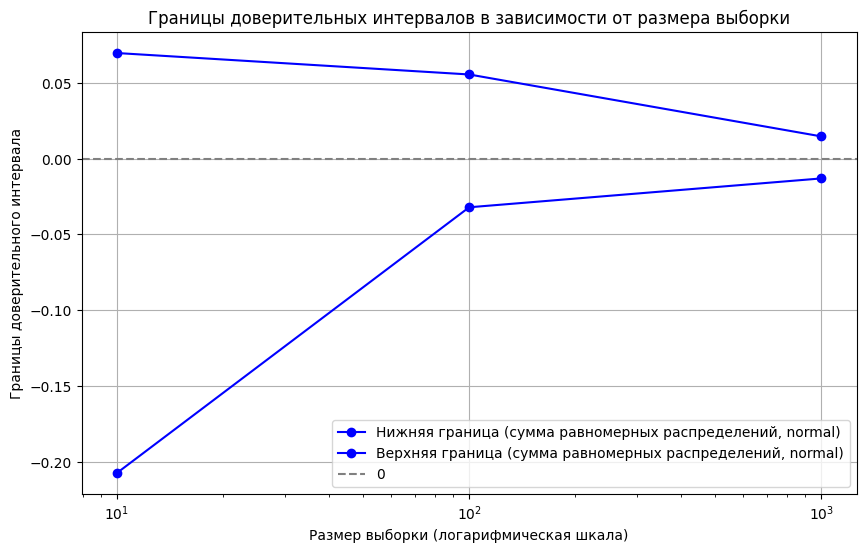

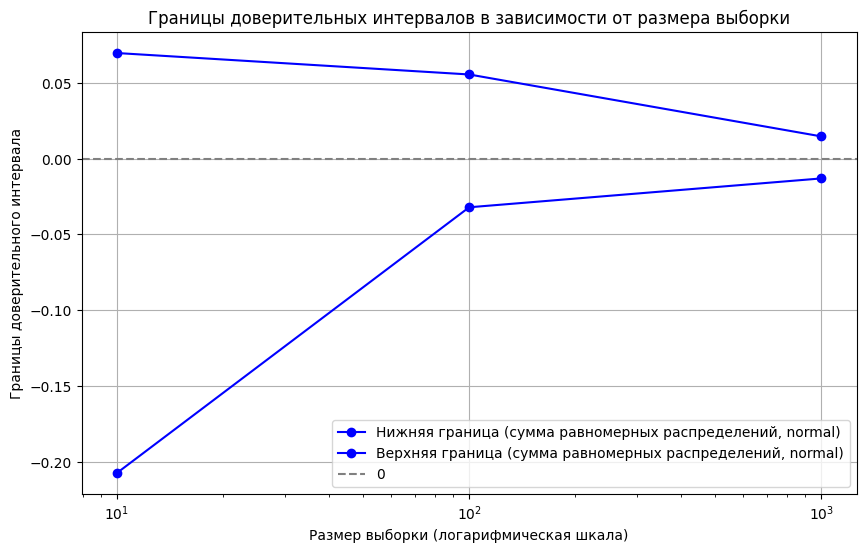

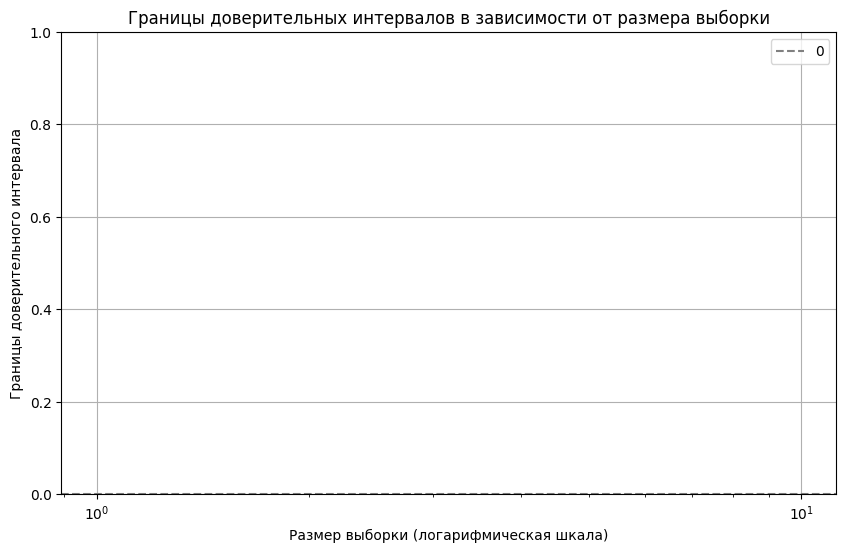

In [21]:
# Параметры распределений с методом джекнайф

# Список для хранения результатов
dist_bounds_jackknife_list = []

# Нормальное распределение с джекнайфом
normal_params = {'mean': 0, 'std': 1}
ci_lower_normal_jackknife, ci_upper_normal_jackknife = compute_interval_bounds(seq_sizes, n_iterations, 'jackknife', 'normal', normal_params, alpha)
dist_bounds_jackknife_list.append((ci_lower_normal_jackknife, ci_upper_normal_jackknife, 'нормальное распределение', 'jackknife'))
visualize_interval_bounds(seq_sizes, dist_bounds_list)
dist_bounds_jackknife_list = []
# Равномерное распределение с джекнайфом
uniform_params = {'low': -1, 'high': 1}
ci_lower_uniform_jackknife, ci_upper_uniform_jackknife = compute_interval_bounds(seq_sizes, n_iterations, 'jackknife', 'uniform', uniform_params, alpha)
dist_bounds_jackknife_list.append((ci_lower_uniform_jackknife, ci_upper_uniform_jackknife, 'равномерное распределение', 'jackknife'))
visualize_interval_bounds(seq_sizes, dist_bounds_list)
dist_bounds_jackknife_list = []
# Сумма равномерных распределений с джекнайфом
sum_uniform_params = {'low': -1, 'high': 1, 'count': 2}
ci_lower_sum_uniform_jackknife, ci_upper_sum_uniform_jackknife = compute_interval_bounds(seq_sizes, n_iterations, 'jackknife', 'sum_of_uniform', sum_uniform_params, alpha)
dist_bounds_jackknife_list.append((ci_lower_sum_uniform_jackknife, ci_upper_sum_uniform_jackknife, 'сумма равномерных распределений', 'jackknife'))
visualize_interval_bounds(seq_sizes, dist_bounds_list)


# Параметры распределений с методом бутстрэп

# Список для хранения результатов
dist_bounds_bootstrap_list = []

# Нормальное распределение с бутстрэпом
normal_params = {'mean': 0, 'std': 1}
ci_lower_normal_bootstrap, ci_upper_normal_bootstrap = compute_interval_bounds(seq_sizes, n_iterations, 'bootstrap', 'normal', normal_params, alpha)
dist_bounds_bootstrap_list.append((ci_lower_normal_bootstrap, ci_upper_normal_bootstrap, 'нормальное распределение', 'бутстрэп'))
visualize_interval_bounds(seq_sizes, dist_bounds_list)
dist_bounds_bootstrap_list = []
# Равномерное распределение с бутстрэпом
uniform_params = {'low': -1, 'high': 1}
ci_lower_uniform_bootstrap, ci_upper_uniform_bootstrap = compute_interval_bounds(seq_sizes, n_iterations, 'bootstrap', 'uniform', uniform_params, alpha)
dist_bounds_bootstrap_list.append((ci_lower_uniform_bootstrap, ci_upper_uniform_bootstrap, 'равномерное распределение', 'бутстрэп'))
visualize_interval_bounds(seq_sizes, dist_bounds_list)
dist_bounds_bootstrap_list = []
# Сумма равномерных распределений с бутстрэпом
sum_uniform_params = {'low': -1, 'high': 1, 'count': 2}
ci_lower_sum_uniform_bootstrap, ci_upper_sum_uniform_bootstrap = compute_interval_bounds(seq_sizes, n_iterations, 'bootstrap', 'sum_of_uniform', sum_uniform_params, alpha)
dist_bounds_bootstrap_list.append((ci_lower_sum_uniform_bootstrap, ci_upper_sum_uniform_bootstrap, 'сумма равномерных распределений', 'бутстрэп'))
visualize_interval_bounds(seq_sizes, dist_bounds_list)
dist_bounds_bootstrap_list = []
# Построение графиков для метода бутстрэп
visualize_interval_bounds(seq_sizes, dist_bounds_bootstrap_list)


#Номер 3


In [15]:
# Функция добавления выбросов в выборку
def inject_outliers(sequence, outlier_count=100, dist_type='normal'):
    if dist_type == 'normal':
        outliers = np.random.normal(loc=np.mean(sequence), scale=10*np.std(sequence), size=outlier_count)
    elif dist_type == 'uniform':
        outliers = np.random.uniform(low=-10, high=10, size=outlier_count)
    elif dist_type == 'sum_of_uniform':
        outliers = np.random.uniform(low=-20, high=20, size=outlier_count)

    return np.concatenate([sequence, outliers])

# Функция расчета доверительных интервалов с выбросами
def compute_interval_bounds_with_outliers(seq_sizes, iter_count, method='normal', dist_type='normal', params=None, conf_level=0.05, outlier_count=100):
    ci_lower_bounds = []
    ci_upper_bounds = []

    for size in seq_sizes:
        lower_bounds = []
        upper_bounds = []

        for _ in range(iter_count):
            sequence = generate_sequence(size, dist_type, params)
            sequence_with_outliers = inject_outliers(sequence, outlier_count=outlier_count, dist_type=dist_type)

            if method == 'jackknife':
                ci_lower, ci_upper = jackknife_ci_method(sequence_with_outliers, conf_level)
            elif method == 'bootstrap':
                ci_lower, ci_upper = bootstrap_ci_method(sequence_with_outliers, conf_level, iter_count)
            elif method == 'normal':
                ci_lower, ci_upper = calculate_ci(sequence_with_outliers, conf_level)

            lower_bounds.append(ci_lower)
            upper_bounds.append(ci_upper)

        ci_lower_bounds.append(np.mean(lower_bounds))
        ci_upper_bounds.append(np.mean(upper_bounds))

    return ci_lower_bounds, ci_upper_bounds


In [23]:
# Размеры выборок
sample_sizes = [10, 100, 500]

# Список доверительных интервалов
ci_bounds_list = []

# Нормальное распределение
normal_params = {'mean': 0, 'std': 1}
ci_lower_bounds_normal, ci_upper_bounds_normal = compute_interval_bounds_with_outliers(sample_sizes, n_iterations, 'normal', 'normal', normal_params, alpha)
ci_bounds_list.append((ci_lower_bounds_normal, ci_upper_bounds_normal, 'нормальное распределение', 'normal'))

# Равномерное распределение
uniform_params = {'low': -1, 'high': 1}
ci_lower_bounds_uniform, ci_upper_bounds_uniform = compute_interval_bounds_with_outliers(sample_sizes, n_iterations, 'normal', 'uniform', uniform_params, alpha)
ci_bounds_list.append((ci_lower_bounds_uniform, ci_upper_bounds_uniform, 'равномерное распределение', 'normal'))

# Сумма двух равномерных распределений
sum_uniform_params = {'low': -1, 'high': 1, 'count': 2}
ci_lower_bounds_sum_uniform, ci_upper_bounds_sum_uniform = compute_interval_bounds_with_outliers(sample_sizes, n_iterations, 'normal', 'sum_of_uniform', sum_uniform_params, alpha)
ci_bounds_list.append((ci_lower_bounds_sum_uniform, ci_upper_bounds_sum_uniform, 'сумма равномерных распределений', 'normal'))


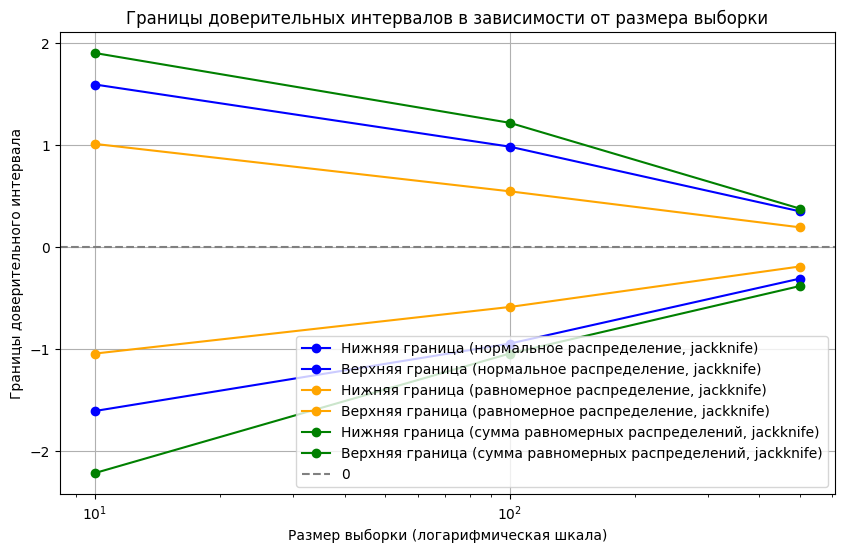

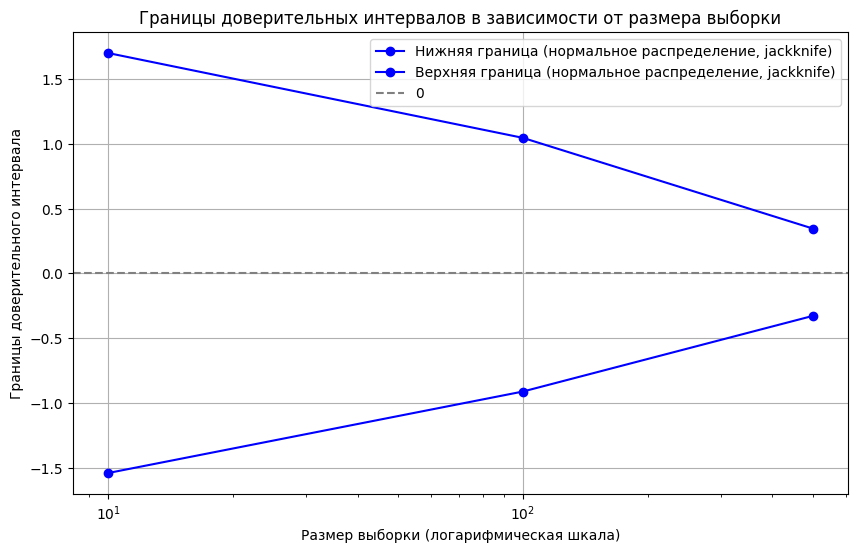

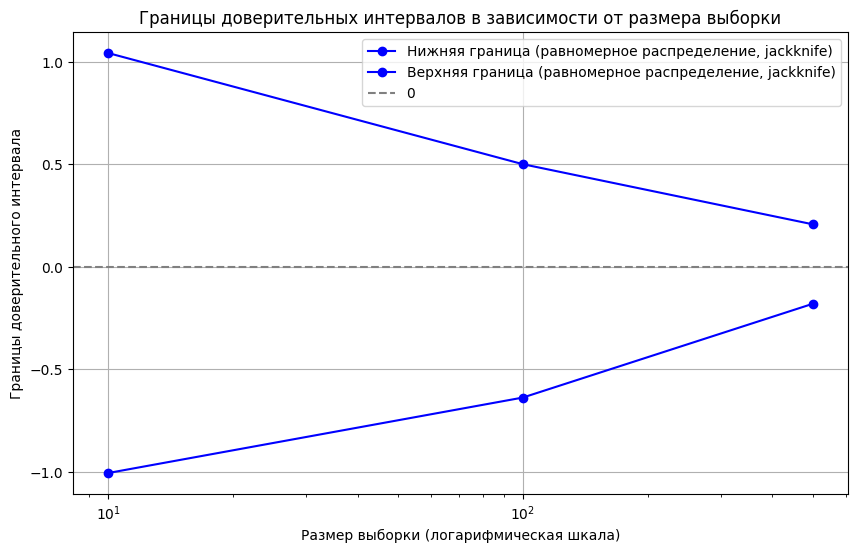

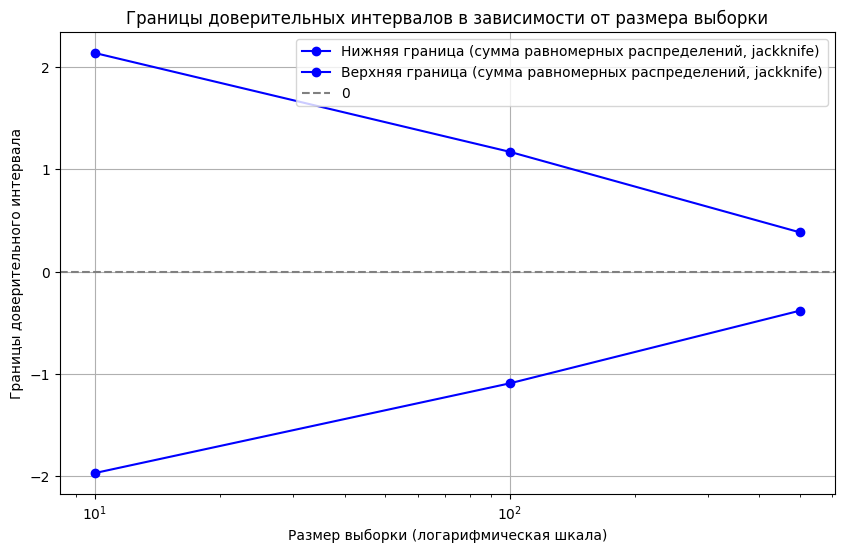

In [26]:

# Построение графиков для нормального метода
visualize_interval_bounds(sample_sizes, ci_bounds_list)

# Список доверительных интервалов для джекнайфа
ci_bounds_list = []

# Нормальное распределение с джекнайфом
ci_lower_bounds_normal_jackknife, ci_upper_bounds_normal_jackknife = compute_interval_bounds_with_outliers(sample_sizes, n_iterations, 'jackknife', 'normal', normal_params, alpha)
ci_bounds_list.append((ci_lower_bounds_normal_jackknife, ci_upper_bounds_normal_jackknife, 'нормальное распределение', 'jackknife'))
visualize_interval_bounds(sample_sizes, ci_bounds_list)
ci_bounds_list = []

# Равномерное распределение с джекнайфом
ci_lower_bounds_uniform_jackknife, ci_upper_bounds_uniform_jackknife = compute_interval_bounds_with_outliers(sample_sizes, n_iterations, 'jackknife', 'uniform', uniform_params, alpha)
ci_bounds_list.append((ci_lower_bounds_uniform_jackknife, ci_upper_bounds_uniform_jackknife, 'равномерное распределение', 'jackknife'))
visualize_interval_bounds(sample_sizes, ci_bounds_list)
ci_bounds_list = []

# Сумма равномерных с джекнайфом
ci_lower_bounds_sum_uniform_jackknife, ci_upper_bounds_sum_uniform_jackknife = compute_interval_bounds_with_outliers(sample_sizes, n_iterations, 'jackknife', 'sum_of_uniform', sum_uniform_params, alpha)
ci_bounds_list.append((ci_lower_bounds_sum_uniform_jackknife, ci_upper_bounds_sum_uniform_jackknife, 'сумма равномерных распределений', 'jackknife'))
visualize_interval_bounds(sample_sizes, ci_bounds_list)
ci_bounds_list = []






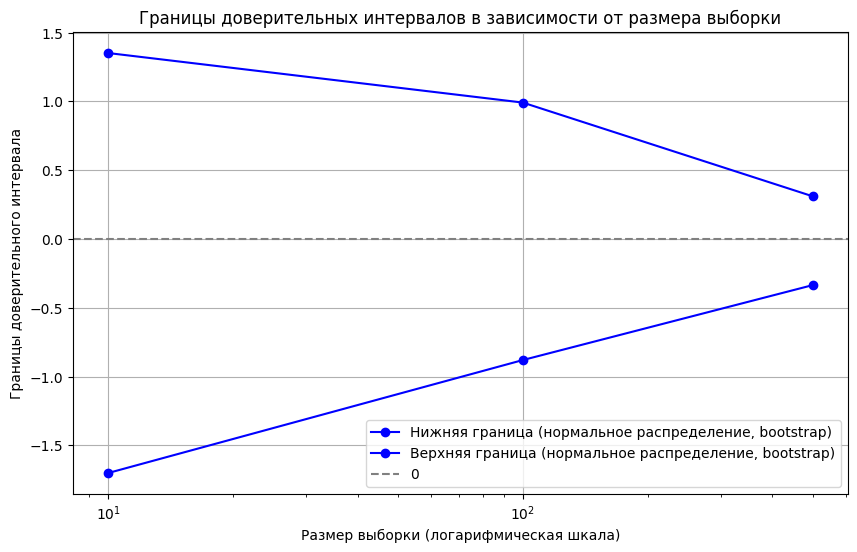

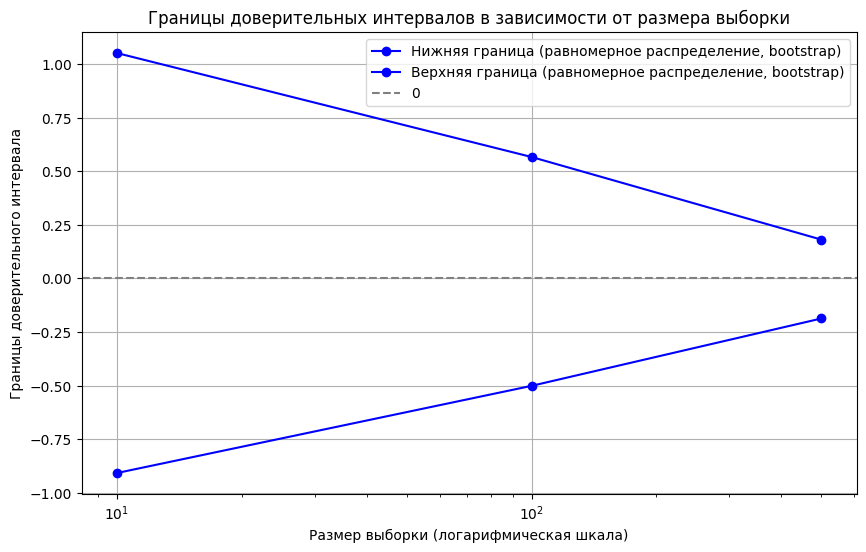

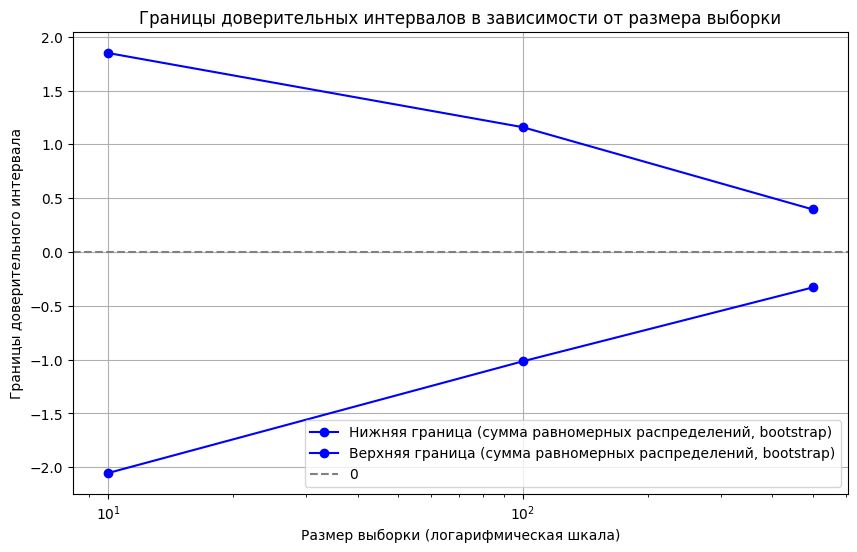

In [27]:
# Список доверительных интервалов для бутстрэп
ci_bounds_bootstrap_list = []

# Нормальное распределение с бутстрэпом
ci_lower_bounds_normal_bootstrap, ci_upper_bounds_normal_bootstrap = compute_interval_bounds_with_outliers(sample_sizes, n_iterations, 'bootstrap', 'normal', normal_params, alpha)
ci_bounds_bootstrap_list.append((ci_lower_bounds_normal_bootstrap, ci_upper_bounds_normal_bootstrap, 'нормальное распределение', 'bootstrap'))
visualize_interval_bounds(sample_sizes, ci_bounds_bootstrap_list)
ci_bounds_bootstrap_list = []
# Равномерное распределение с бутстрэпом
ci_lower_bounds_uniform_bootstrap, ci_upper_bounds_uniform_bootstrap = compute_interval_bounds_with_outliers(sample_sizes, n_iterations, 'bootstrap', 'uniform', uniform_params, alpha)
ci_bounds_bootstrap_list.append((ci_lower_bounds_uniform_bootstrap, ci_upper_bounds_uniform_bootstrap, 'равномерное распределение', 'bootstrap'))
visualize_interval_bounds(sample_sizes, ci_bounds_bootstrap_list)
ci_bounds_bootstrap_list = []
# Сумма равномерных с бутстрэпом
ci_lower_bounds_sum_uniform_bootstrap, ci_upper_bounds_sum_uniform_bootstrap = compute_interval_bounds_with_outliers(sample_sizes, n_iterations, 'bootstrap', 'sum_of_uniform', sum_uniform_params, alpha)
ci_bounds_bootstrap_list.append((ci_lower_bounds_sum_uniform_bootstrap, ci_upper_bounds_sum_uniform_bootstrap, 'сумма равномерных распределений', 'bootstrap'))
visualize_interval_bounds(sample_sizes, ci_bounds_bootstrap_list)
ci_bounds_bootstrap_list = []